# Python ile Zaman Serisi Analizi ve Tahmini

Zaman Serisi Analizi , verilerden istatistiksel özellikler çıkarmak için zaman serisi  istatistiklerini araştırmak için yöntemler taşır. Zaman Serisi Tahmini,   tarihsel önemi kullanarak gelecekteki değerleri tahmin etmek için bir Makine  öğrenimi  modelinin eğitiminde kullanılır.

Zaman Serisi Analizi genel olarak Ekonomi, Hava tahmini, hisse senedi fiyatı tahmini ve ayrıca Satış tahmini için makine öğrenimi modellerinin eğitiminde kullanılır.

Durağan olmayan özelliklere dayalı olgularda Zaman Serisi Analizinin yaygın olarak kullanıldığı söylenebilir.

Bu yazımda python ile zaman serisi analizini kullanarak satış tahmini için farklı yöntemler kullanacağım

In [56]:
import warnings
import itertools
import numpy as np
import matplotlib.pyplot as plt
warnings.filterwarnings("ignore")
plt.style.use('fivethirtyeight')
import pandas as pd
import statsmodels.api as sm
import matplotlib
matplotlib.rcParams['axes.labelsize'] = 14
matplotlib.rcParams['xtick.labelsize'] = 12
matplotlib.rcParams['ytick.labelsize'] = 12
matplotlib.rcParams['text.color'] = 'k'

Python ile excel dosyalarını okumak adına bilgisayarımıza 'xlrd' dosyasını yüklememiz gerekli

In [57]:
pip install xlrd

Note: you may need to restart the kernel to use updated packages.


Veri setinde farklı kategoriler var, zaman serileri analizinden ve mobilya satış tahminlerinden başlayalım

In [58]:
df = pd.read_excel("Sample - Superstore.xls")
furniture = df.loc[df['Category'] == 'Furniture']
furniture['Order Date'].min(), furniture['Order Date'].max()

(Timestamp('2014-01-06 00:00:00'), Timestamp('2017-12-30 00:00:00'))

### Veri Ön İşleme


Veri Ön İşleme, ihtiyacımız olmayan sütunları kaldırmayı, eksik değerleri aramayı vb. içerir

In [59]:
cols = ['Row ID', 'Order ID', 'Ship Date', 'Ship Mode', 
        'Customer ID', 'Customer Name', 
        'Segment', 'Country', 'City', 'State', 
        'Postal Code', 'Region', 'Product ID', 
        'Category', 'Sub-Category', 'Product Name', 
        'Quantity', 'Discount', 'Profit']
furniture.drop(cols, axis=1, inplace=True)
furniture = furniture.sort_values('Order Date')
furniture.isnull().sum()

Order Date    0
Sales         0
dtype: int64

In [60]:
furniture = furniture.groupby('Order Date')['Sales'].sum().reset_index()

### Zaman Serisi Verilerini İndeksleme

In [61]:
furniture = furniture.set_index('Order Date')
furniture.index

DatetimeIndex(['2014-01-06', '2014-01-07', '2014-01-10', '2014-01-11',
               '2014-01-13', '2014-01-14', '2014-01-16', '2014-01-19',
               '2014-01-20', '2014-01-21',
               ...
               '2017-12-18', '2017-12-19', '2017-12-21', '2017-12-22',
               '2017-12-23', '2017-12-24', '2017-12-25', '2017-12-28',
               '2017-12-29', '2017-12-30'],
              dtype='datetime64[ns]', name='Order Date', length=889, freq=None)

Mevcut DateTime veri kümesi içinde çalışmak için biraz zor görünüyor, bu yüzden basit tutmak için her gün satışların fiyatını ayın ortalamasında kullanacağım. Her ayın başlangıcını zaman damgası olarak kullanacağım

In [62]:
y = furniture['Sales'].resample('MS').mean()

### Mobilya Satış Verilerini Görselleştirme

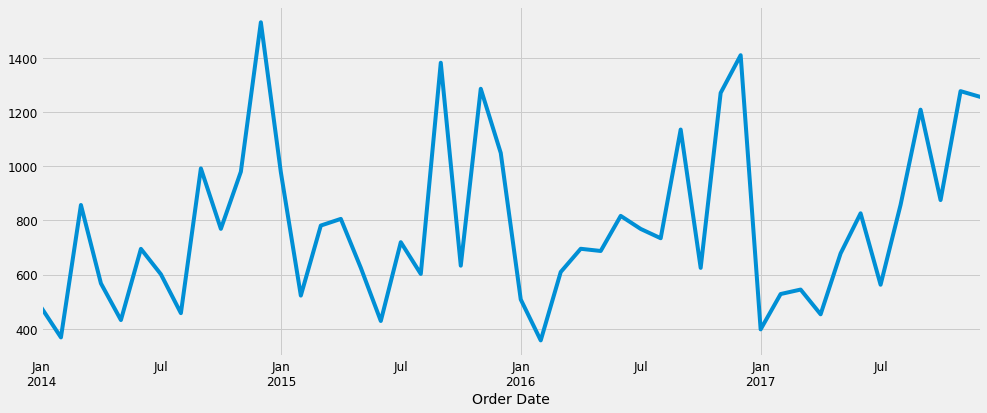

In [63]:
y.plot(figsize=(15, 6))
plt.show()

Yukarıdaki şekilden bazı kalıplar çizilebilir, zaman serisi mevsimsel olarak kalıplanır, örneğin satışlar her yılın başında düşüktür ve yıl sonunda satışlar artar.

Şimdi, zaman serilerimizin üç bileşene ayrılmasını sağlayacak olan zaman serisi ayrıştırma yöntemini kullanarak bu verileri görselleştirelim:

1.Akım

2.Mevsim

3.Gürültü

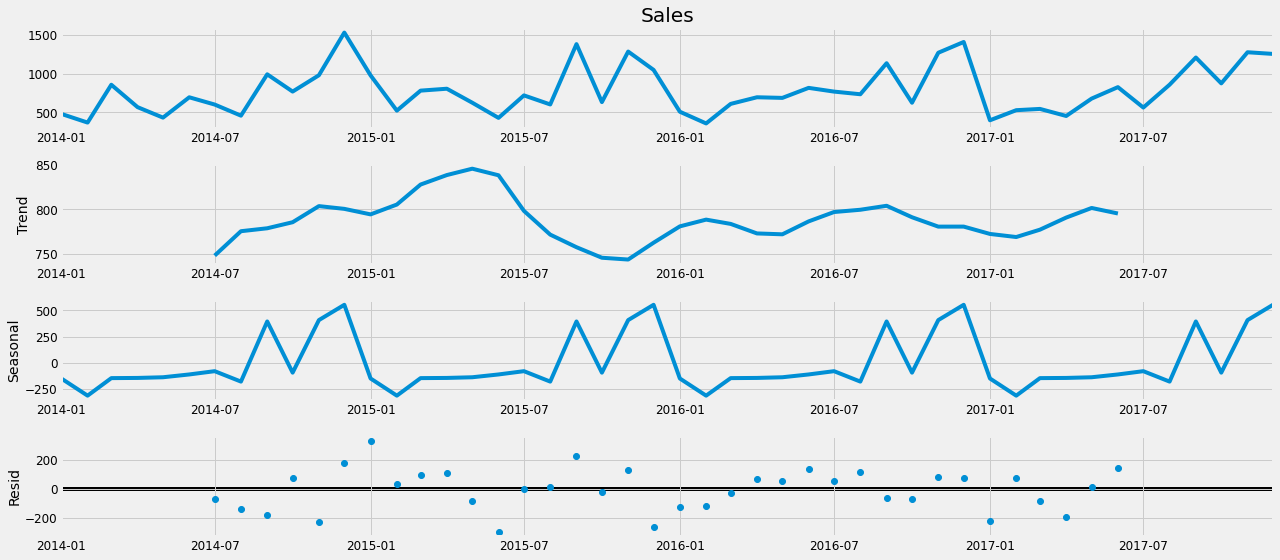

In [64]:
from pylab import rcParams
rcParams['figure.figsize'] = 18, 8
decomposition = sm.tsa.seasonal_decompose(y, model='additive')
fig = decomposition.plot()
plt.show()

Yukarıdaki şekil mobilya satışlarının mevsimler nedeniyle sabit olmadığını göstermektedir

## ARIMA ile Zaman Serisi Tahmini

ARIMA, zaman serisi tahmininde en çok kullanılan yöntemlerden biridir. ARIMA, Otoregresif Entegre Hareketli Ortalama anlamına gelir. Şimdi ARIMA yöntemini daha sonraki zaman serisi tahmini sürecinde kullanacağım

In [65]:
p = d = q = range(0, 2)
pdq = list(itertools.product(p, d, q))
seasonal_pdq = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))]
print('Examples of parameter combinations for Seasonal ARIMA...')
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[1]))
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[2]))
print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[3]))
print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[4]))

Examples of parameter combinations for Seasonal ARIMA...
SARIMAX: (0, 0, 1) x (0, 0, 1, 12)
SARIMAX: (0, 0, 1) x (0, 1, 0, 12)
SARIMAX: (0, 1, 0) x (0, 1, 1, 12)
SARIMAX: (0, 1, 0) x (1, 0, 0, 12)


Bu adım, mobilya satışları için Zaman Serisi Tahmin modelimizde parametrelerin seçim sürecidir

In [66]:
for param in pdq:
    for param_seasonal in seasonal_pdq:
        try:
            mod = sm.tsa.statespace.SARIMAX(y,
                                            order=param,
                                            seasonal_order=param_seasonal,
                                            enforce_stationarity=False,
                                            enforce_invertibility=False)
            results = mod.fit()
            print('ARIMA{}x{}12 - AIC:{}'.format(param, param_seasonal, results.aic))
        except:
            continue

ARIMA(0, 0, 0)x(0, 0, 0, 12)12 - AIC:769.0817523205915
ARIMA(0, 0, 0)x(0, 0, 1, 12)12 - AIC:1457.5412534942598
ARIMA(0, 0, 0)x(0, 1, 0, 12)12 - AIC:477.7170130919703
ARIMA(0, 0, 0)x(0, 1, 1, 12)12 - AIC:302.27028997935736
ARIMA(0, 0, 0)x(1, 0, 0, 12)12 - AIC:497.2314433418338
ARIMA(0, 0, 0)x(1, 0, 1, 12)12 - AIC:1179.6903776415356
ARIMA(0, 0, 0)x(1, 1, 0, 12)12 - AIC:318.0047199116341
ARIMA(0, 0, 0)x(1, 1, 1, 12)12 - AIC:304.24882803033336
ARIMA(0, 0, 1)x(0, 0, 0, 12)12 - AIC:720.9252270758095
ARIMA(0, 0, 1)x(0, 0, 1, 12)12 - AIC:2621.5327370301484
ARIMA(0, 0, 1)x(0, 1, 0, 12)12 - AIC:466.56074298091517
ARIMA(0, 0, 1)x(0, 1, 1, 12)12 - AIC:291.62613896732915
ARIMA(0, 0, 1)x(1, 0, 0, 12)12 - AIC:499.5634719720483
ARIMA(0, 0, 1)x(1, 0, 1, 12)12 - AIC:2556.28914808803
ARIMA(0, 0, 1)x(1, 1, 0, 12)12 - AIC:319.9884876946868
ARIMA(0, 0, 1)x(1, 1, 1, 12)12 - AIC:291.8725576454926
ARIMA(0, 1, 0)x(0, 0, 0, 12)12 - AIC:677.8947668259312
ARIMA(0, 1, 0)x(0, 0, 1, 12)12 - AIC:1295.1066017507496
ARI

### ARIMA Modelinin Montajı

In [67]:
mod = sm.tsa.statespace.SARIMAX(y,
                                order=(1, 1, 1),
                                seasonal_order=(1, 1, 0, 12),
                              #  enforce_stationarity=False,
                                enforce_invertibility=False)
results = mod.fit()
print(results.summary().tables[1])

                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.0676      0.226      0.299      0.765      -0.376       0.511
ma.L1         -1.0000      0.279     -3.590      0.000      -1.546      -0.454
ar.S.L12      -0.4807      0.147     -3.260      0.001      -0.770      -0.192
sigma2      4.108e+04   6.78e-06   6.06e+09      0.000    4.11e+04    4.11e+04


Şimdi Model teşhisini çalıştıracağım; Modeldeki herhangi bir olağandışı davranışı araştırmak için Zaman Serisi Tahmininde bir model teşhisi yapmak çok önemlidir

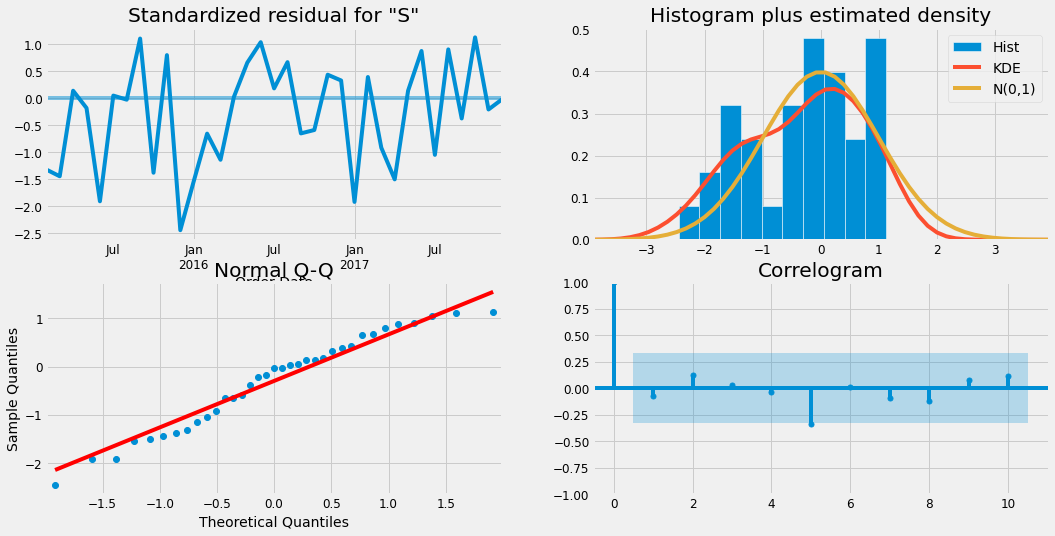

In [68]:
results.plot_diagnostics(figsize=(16, 8))
plt.show()

### Zaman Serisi Tahminlerini Doğrulama

Zaman serisi tahmin modelimizin doğruluğunu anlamak için, tahmin edilen satışları gerçek satışlarla karşılaştıracağım ve tahminleri 2017-01-01'de başlayacak ve veri setinin sonuna kadar ayarlayacağım

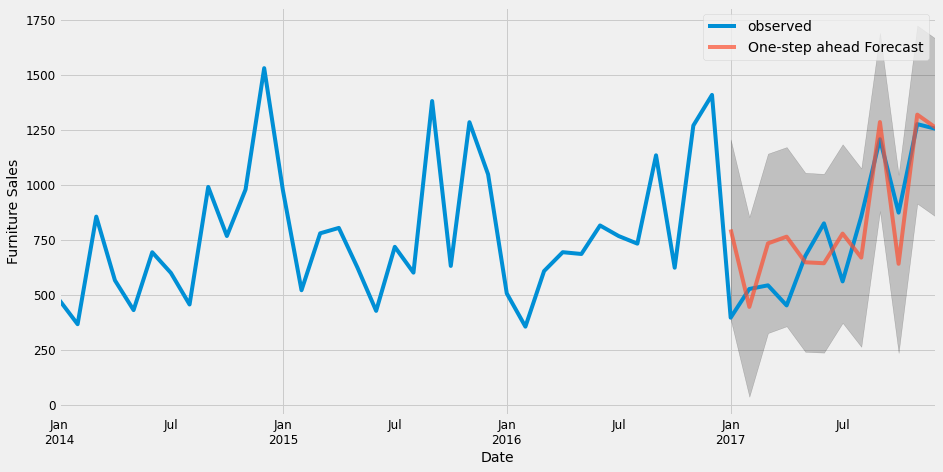

In [69]:
pred = results.get_prediction(start=pd.to_datetime('2017-01-01'), dynamic=False)
pred_ci = pred.conf_int()
ax = y['2014':].plot(label='observed')
pred.predicted_mean.plot(ax=ax, label='One-step ahead Forecast', alpha=.7, figsize=(14, 7))
ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.2)
ax.set_xlabel('Date')
ax.set_ylabel('Furniture Sales')
plt.legend()
plt.show()

Yukarıdaki şekil, tahmin tahminleriyle karşılaştırıldığında gözlemlenen değerleri göstermektedir. Resim, başlangıçta yukarı doğru bir kayma gösteren ve yılın sonunda mevsimselliği yakalayan gerçek satışlarla uyumludur

In [70]:
y_forecasted = pred.predicted_mean
y_truth = y['2017-01-01':]
mse = ((y_forecasted - y_truth) ** 2).mean()
print('ahminlerimizin Ortalama Kare Hatası {}'.format(round(mse, 2)))

ahminlerimizin Ortalama Kare Hatası 39996.01


In [71]:
print('Tahminlerimizin Kök Ortalama Kare Hatası {}'.format(round(np.sqrt(mse), 2)))

Tahminlerimizin Kök Ortalama Kare Hatası 199.99


İstatistikte, bir tahmincinin Ortalama Karesi Hatası (MSE)  , hatanın karelerinin ortalamasını  , yani beklenen değerler arasındaki ortak kareler ayrımını ve tahmin edileni ölçer. MSE, bir tahmincinin cezasının bir ölçüsüdür, milleri sürekli olarak negatif değildir ve MSE ne kadar küçükse, mükemmel bir  uyum yolunu bulmaya o kadar yakın oluruz .

Kök Ortalama Kare Hatası (RMSE),   sürümümüzün  test setindeki  ortalama   günlük  mobilya  gelirini  gerçek gelirin 151,64'ü içinde tahmin  edebildiğini   söylüyor  . Mobilyalarımızın  günlük geliri  400'den 1200'ün üzerine çıkıyor. Bana göre  bu şu ana kadar oldukça  iyi   bir  versiyon

### Tahminlerin üretilmesi ve görselleştirilmesi

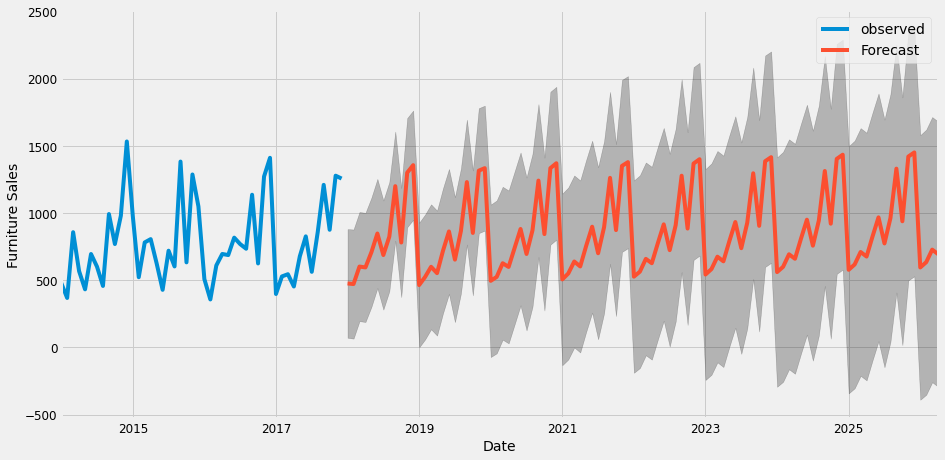

In [72]:
pred_uc = results.get_forecast(steps=100)
pred_ci = pred_uc.conf_int()
ax = y.plot(label='observed', figsize=(14, 7))
pred_uc.predicted_mean.plot(ax=ax, label='Forecast')
ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.25)
ax.set_xlabel('Date')
ax.set_ylabel('Furniture Sales')
plt.legend()
plt.show()

Time Series Forecasting modelimiz, hiç şüphesiz, mobilya karlarını mevsimsellikten çıkardı. Geleceğe yönelik tahminlerde bulundukça, değerlerimizden çok daha az emin olmamız çok doğal. Bu, benzer şekilde geleceğe doğru hareket ettikçe daha önemli hale gelen modelimiz aracılığıyla oluşturulan kendine inanç aralıkları yoluyla yansıtılır